# Problem statement
- we need to Build image classifier using CNN(DENSENET architecture) with CIFAR-10 dataset

### Using DENSENET architecture

In [1]:
# Load necessary libraries
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam, SGD 

from numpy import expand_dims
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from matplotlib import pyplot
from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import Callback, EarlyStopping
import datetime

In [ ]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [2]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [3]:
# mounted my Google Drive in colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !ls /content/gdrive/My\ Drive

In [ ]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [ ]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
X_test.shape

(10000, 32, 32, 3)

In [ ]:
y_train.shape

(50000, 10)

In [ ]:
y_test.shape

(10000, 10)

In [ ]:
def normalize_pixels(train, test):
    '''
    Normalize data into range of 0 to 1
    '''
    train_norm = train.astype('float32')
    test_norm  = test.astype('float32')
    
    train_norm /= 255
    test_norm /= 255
    
    return (train_norm, test_norm)

In [ ]:
X_train,X_test=normalize_pixels(X_train,X_test)

In [ ]:
#https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
sample_image=X_train[1]
sample_image.shape

(32, 32, 3)

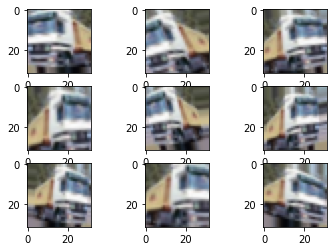

In [ ]:
sample_images = expand_dims(sample_image, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range = 15, horizontal_flip = True, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.2, shear_range = 15)
                      
# prepare iterator
it = datagen.flow(sample_images, batch_size=1)
# generate sample images and plot
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    image = batch[0];
    # plot raw pixel data
    pyplot.imshow(image)

# show the figure
pyplot.show()

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/cifar assignment/weights.h5',  # filepath where to save the weights
    save_weights_only=True,  # save only the weights, not the entire model
    period=1,  # save weights every epoch
    save_best_only=False,  # save the weights at the end of every epoch, regardless of whether the model improved
    save_freq='epoch'  # save the weights at the end of every epoch
)


logdir="/content/drive/MyDrive/cifar assignment/logs" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=logdir)

class TestAccuracyStopping(tf.keras.callbacks.Callback):
    def __init__(self, test_data, threshold):
        self.test_data = test_data
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        if acc >= self.threshold:
            print('\nReached %0.2f%% accuracy, stopping training' % (acc * 100))
            self.model.stop_training = True
stopping_callback = TestAccuracyStopping(test_data=(X_test, y_test), threshold=0.91)

In [ ]:
#https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
def model_summarize(history):
    '''
    Summarize model i.e. print train and test loss
    '''
    # plot loss
    pyplot.subplot(121)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    pyplot.xlabel('epoch')
    pyplot.ylabel('loss')
    pyplot.show()

In [ ]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [ ]:
def model_harness(X_train, y_train, X_test, y_test, given_batch_size, given_step_size, given_epochs):
    '''
    define model using data augmentation technique and extend it to it's vertical limit
    '''

    datagen=ImageDataGenerator(rotation_range = 15, horizontal_flip = True, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.2, shear_range = 15)
                     
    # prepare iterator
    iterator_train = datagen.flow(X_train, y_train, batch_size=given_batch_size)
    # fit model
    steps = int(X_train.shape[0] / given_step_size)
    history = model.fit_generator(iterator_train, steps_per_epoch=steps, epochs=given_epochs, validation_data=(X_test, y_test), verbose=1, callbacks=[checkpoint_callback,stopping_callback,tensorboard])
    # evaluate model
    _, acc = model.evaluate(X_test, y_test, verbose=1)
    print('> %.3f' % (acc * 100.0))

    # learning curves
    model_summarize(history)

In [ ]:
num_filter = 36
dropout_rate = 0
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [ ]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 36)   972         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 36)  144         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 36)   0           ['batch_normalization[0][0]']

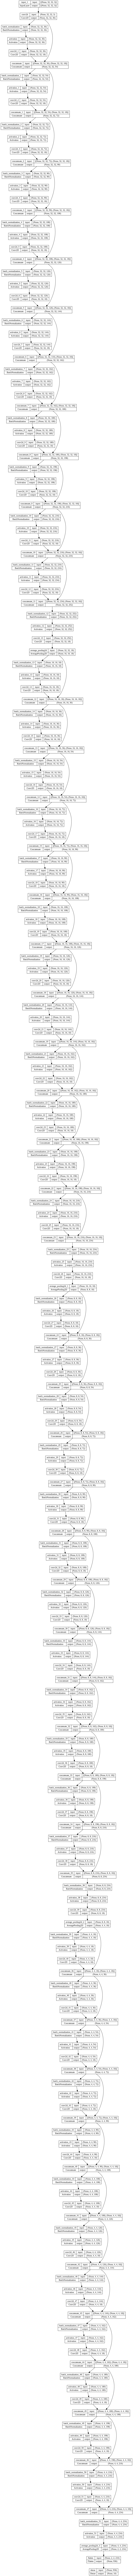

In [ ]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/cifar assignment/model_1.png', show_shapes=True, show_layer_names=True)

In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'] )

<ipython-input-23-052fc875d3a0>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(iterator_train, steps_per_epoch=steps, epochs=given_epochs, validation_data=(X_test, y_test), verbose=1, callbacks=[checkpoint_callback,stopping_callback,tensorboard])


Epoch 1/300
  6/781 [..............................] - ETA: 3:54 - loss: 2.5045 - accuracy: 0.1094

781/781 [==============================] - 129s 145ms/step - loss: 1.5401 - accuracy: 0.4392 - val_loss: 1.1973 - val_accuracy: 0.5670
Epoch 2/300
781/781 [==============================] - 109s 139ms/step - loss: 1.1326 - accuracy: 0.5947 - val_loss: 1.8090 - val_accuracy: 0.4884
Epoch 3/300
781/781 [==============================] - 109s 139ms/step - loss: 0.9452 - accuracy: 0.6653 - val_loss: 1.0792 - val_accuracy: 0.6317
Epoch 4/300
781/781 [==============================] - 107s 137ms/step - loss: 0.8351 - accuracy: 0.7054 - val_loss: 0.9177 - val_accuracy: 0.6889
Epoch 5/300
781/781 [==============================] - 107s 137ms/step - loss: 0.7605 - accuracy: 0.7324 - val_loss: 0.9136 - val_accuracy: 0.6995
Epoch 6/300
781/781 [==============================] - 106s 136ms/step - loss: 0.6943 - accuracy: 0.7574 - val_loss: 0.8603 - val_accuracy: 0.7220
Epoch 7/300
781/781 [==============================] - 107s 136ms/step - loss: 0.6573 - accuracy: 0.7715 - val_loss: 0.6480 - val_

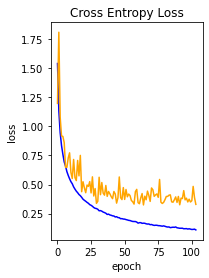

In [ ]:
model_harness(X_train, y_train, X_test, y_test, 64, 64, 300)

In [ ]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_with_dense_layer.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
!cp -r "/content/DNST_model_with_dense_layer.h5" "/content/drive/MyDrive/cifar assignment" 

In [ ]:
# free model variable
#del model

In [ ]:
#model.load_weights('weights.h5')

In [20]:
# Please compare all your models using Prettytable library
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable


x = PrettyTable()
x.field_names = [ "Model", "Epochs","Number of total parameters" ,"Train Accuracy", "Test Accuracy"]
x.add_row(["DenseNet", '104','995,230(less than 1 Million)' , '96.15%', '91.37%'])

print(x)

+----------+--------+------------------------------+----------------+---------------+
|  Model   | Epochs |  Number of total parameters  | Train Accuracy | Test Accuracy |
+----------+--------+------------------------------+----------------+---------------+
| DenseNet |  104   | 995,230(less than 1 Million) |     96.15%     |     91.37%    |
+----------+--------+------------------------------+----------------+---------------+
